In [3]:
import sys
import numpy as np
import pandas as pd
import networkx as nx
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.cluster import DBSCAN
from shapely.ops import unary_union
from itertools import combinations, chain

sys.path.append(str(Path.cwd()))

from _helpers import get_circles, generate_color_list, get_region_value

In [4]:
shape = gpd.read_file(Path.cwd() /
        'misc_data' /
        'zip_data' /
        'backup_copy' /
        'resources' /
        'US_2021' /
        'bus_regions' /
        'regions_onshore_elec_s_100flex.geojson' /
        'regions_onshore_elec_s_100flex.geojson'
        )

usa_total = gpd.GeoDataFrame(geometry=[unary_union(shape['geometry'])]).set_crs(shape.crs)

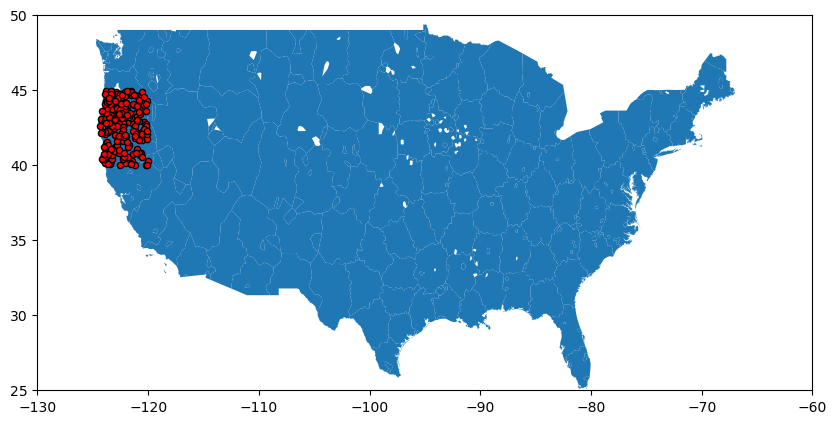

In [5]:
n = 500

sites = gpd.GeoDataFrame(
    {'demand': np.random.uniform(1, 10, n)},
    geometry=gpd.points_from_xy(
        # np.random.uniform(-130, -60, 1000),
        # np.random.uniform(25, 50, 1000)
        np.random.uniform(-130, -120, n),
        np.random.uniform(40, 45, n)
        )
    ).set_crs(epsg=4326)

# sites = sites.sjoin(usa_total, how='inner')
sites = sites.sjoin(shape, how='inner')
fig, ax = plt.subplots(figsize=(10, 10))

shape.plot(ax=ax)
sites.plot(ax=ax, color='red', edgecolor='black', markersize=20)

ax.set_xlim(-130, -60)
ax.set_ylim(25, 50)

plt.show()

In [6]:
def get_plant_capex(demand):
    return 500 + 1000 / (demand + 1)

In [7]:
def to_peaked_graph(points, min_widths):
    G = nx.Graph()

    for i, (x, y) in enumerate(points):
        G.add_node(i, pos=(x, y), min_width=min_widths[i])

    for i in range(len(points)):
        for j in range(i + 1, len(points)):

            length = np.linalg.norm(np.array(points[i]) - np.array(points[j]))
            width = max(min_widths[i], min_widths[j])
            cost = length * width

            G.add_edge(i, j, weight=cost)

    nx.minimum_spanning_tree(G, weight='weight')

    return G


def measure_graph(G):
    total = 0

    for u, v in G.edges():
        p1 = np.array(G.nodes[u]['pos'])
        p2 = np.array(G.nodes[v]['pos'])

        total += np.linalg.norm(p1 - p2)
    
    return total


In [8]:
def get_partitions(elements):

    def get_naive_partitions(elements):
        if not elements:
            return [[]]

        result = []
        for i in range(1, len(elements) + 1):
            for combo in combinations(elements, i):
                remaining_elements = [e for e in elements if e not in combo]
                for rest in get_naive_partitions(remaining_elements):
                    result.append([tuple(combo)] + rest)
        
        return result


    all_partitions = get_naive_partitions(elements)

    def remove_permutations(lst):
        seen = list()
        cleaned_list = []

        for element in lst:
            sorted_element = sorted(element)

            if sorted_element not in seen:
                cleaned_list.append(element)
                seen.append(sorted_element)

        return cleaned_list


    return remove_permutations(all_partitions)

      demand                     geometry  index_right    name           x  \
8   7.067417  POINT (-123.41550 40.08092)           15  US0 22 -122.189899   
13  2.202069  POINT (-121.17003 42.65351)           15  US0 22 -122.189899   
16  1.025544  POINT (-120.27154 41.88184)           15  US0 22 -122.189899   
20  6.799878  POINT (-123.66641 42.22637)           15  US0 22 -122.189899   
36  4.824079  POINT (-123.48963 41.01336)           15  US0 22 -122.189899   

            y country  
8   41.424951      US  
13  41.424951      US  
16  41.424951      US  
20  41.424951      US  
36  41.424951      US  
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -1}
partitions
[[(0,), (1,)], [(0, 1)]]
[(0,), (1,)]
p_cost
[812.2980702974482, 678.7547142523364]
[(0, 1)]
p_cost
[633.0430224700999]
partitions
[[(0,), (1,)], [(0, 1)]]
partition_costs
[1491.0527845497845, 633.0430224700999]
best_partition
[(0, 1)]
best_partition_caps
[6.796327151731521]
best_partition_cluster_sizes
[2]


SystemExit: 

c:\Users\lukas\miniforge3\envs\pypsa-eur\lib\site-packages\IPython\core\interactiveshell.py:3534: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


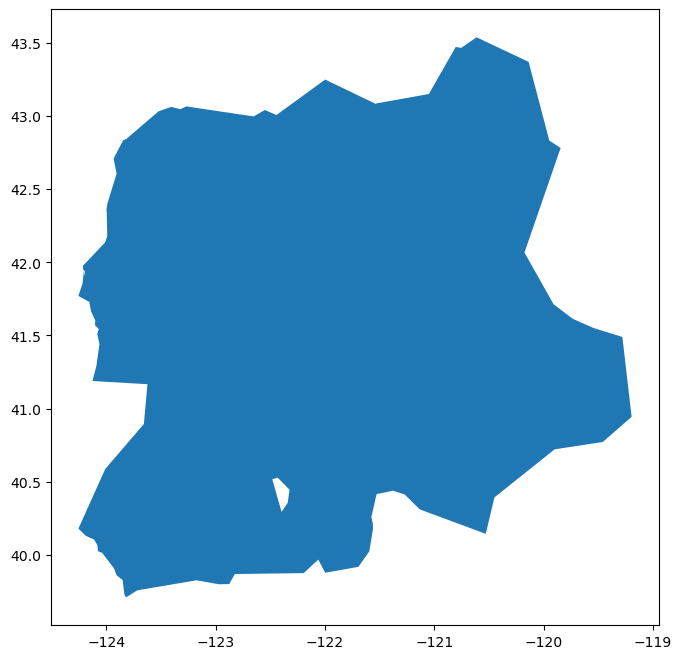

In [47]:
from shapely.geometry import MultiPoint
from sklearn.metrics.pairwise import haversine_distances


pipe_price = 5

threshold_distance_km = 10
threshold_distance_rad = threshold_distance_km / 6371.0


for index_right in sites.index_right.value_counts().index:

    ss = sites.loc[sites.index_right == index_right]

    if ss.empty:
        continue

    print(ss.head())

    sites_np = np.array([ss['geometry'].y, ss['geometry'].x]).T

    db = DBSCAN(
        eps=threshold_distance_rad,
        min_samples=2,
        metric='haversine').fit(np.radians(sites_np))

    labels = db.labels_

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    shape.loc[[index_right]].plot(ax=ax)

    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

    print(unique_labels)
    caps, capex, cluster_size = [], [], []

    for k, col in zip(unique_labels, colors):

        class_member_mask = (labels == k)

        xy = sites_np[class_member_mask]
        size = ss.iloc[class_member_mask]['demand']

        if k == -1:
            col = [0, 0, 0, 1]

            caps.extend(size)
            capex.extend(get_plant_capex(np.array(size)))
            cluster_size.extend([1] * len(size))

        else:
            partitions = get_partitions(list(range(len(xy))))
            partition_costs = []
            
            partition_caps = []
            partition_cluster_sizes = []

            print('partitions')
            print(partitions)

            for i, partition in enumerate(partitions):

                p_cost = []
                p_caps = []
                p_cluster_size = []

                for group_idx in partition:
                    
                    '''
                    print('-------------------------')
                    print('group_idx')
                    print(group_idx)
                    print('xy')
                    print(xy)
                    print('p_xy')
                    print(p_xy)
                    print(p_xy.shape)
                    '''

                    p_xy = xy[[group_idx]][0]

                    p_size = size.iloc[list(group_idx)]
                    p_cluster_size.append(len(p_size))

                    if len(p_size) == 1:

                        p_caps.extend(p_size)
                        p_cost.extend(get_plant_capex(np.array(p_size)))

                    else:

                        n_well_test_sqrt = 10

                        if len(p_size) == 2:

                            # cost-optimal well placement will always just be at larger demand site; redundant approach?
                            well_proposals = gpd.GeoSeries(
                                gpd.points_from_xy(
                                np.linspace(p_xy[0, 1], p_xy[1, 1], 2),
                                np.linspace(p_xy[0, 0], p_xy[1, 0], 2)
                                )
                            )

                        else:

                            xrange = np.linspace(p_xy[:, 1].min(), p_xy[:, 1].max(), n_well_test_sqrt)
                            yrange = np.linspace(p_xy[:, 0].min(), p_xy[:, 0].max(), n_well_test_sqrt)

                            well_proposals = gpd.GeoSeries(
                                gpd.points_from_xy(
                                np.stack([xrange for _ in range(n_well_test_sqrt)], axis=1).flatten(),
                                np.stack([yrange for _ in range(n_well_test_sqrt)], axis=1).T.flatten(),
                                )
                            )

                            hull = MultiPoint(p_xy[:,::-1]).convex_hull
                            well_proposals = (
                                well_proposals
                                .loc[well_proposals.within(hull)]
                            )

                        pipe_lengths, well_xs, well_ys = [], [], []

                        for well in well_proposals:

                            well_coords = np.array(well.coords)[0][::-1]
                            well_xs.append(well_coords[1])
                            well_ys.append(well_coords[0])

                            layout = (
                                np.vstack([p_xy, well_coords])
                            )

                            pipe_lengths.append(measure_graph(
                                to_peaked_graph(
                                    layout,
                                    p_size.tolist() + [0]
                                    )))

                        results = pd.DataFrame({
                            'pipe_lengths': pipe_lengths,
                            'well_xs': well_xs,
                            'well_ys': well_ys
                        })

                        assert not results.empty

                        results = results.sort_values('pipe_lengths').iloc[0]
                        pipe_cost = results['pipe_lengths'] / 360 * 6371 * pipe_price

                        total_cost = pipe_cost + get_plant_capex(size.sum())

                        p_cost.append(total_cost)
                        p_caps.append(p_size.sum())

                    # print(p_cost)
                    # print(p_caps)
                    # print(p_cluster_size)

                print(partition)
                print('p_cost')
                print(p_cost)

                partition_costs.append(sum(p_cost))
                partition_caps.append(p_caps)
                partition_cluster_sizes.append(p_cluster_size)

                # import sys
                # sys.exit()
            
            print('partitions')
            print(partitions)

            print('partition_costs')
            print(partition_costs)

            best_partition = partitions[np.argmin(partition_costs)]
            best_partition_caps = partition_caps[np.argmin(partition_costs)]
            best_partition_cluster_sizes = partition_cluster_sizes[np.argmin(partition_costs)]

            print('best_partition')
            print(best_partition)
            print('best_partition_caps')
            print(best_partition_caps)
            print('best_partition_cluster_sizes')
            print(best_partition_cluster_sizes)
            import sys
            sys.exit()

            caps.append(size.sum())
            capex.append(total_cost)
            cluster_size.append(len(size))
            
        ax.scatter(
            xy[:, 1],
            xy[:, 0],
            color=tuple(col),
            edgecolor='k',
            alpha=1,
            s=size*20
            )


    ax.set_title(f'Estimated number of clusters: {n_clusters}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    # ax.set_xlim(xy[:, 1].min() - 0.1, xy[:, 1].max() + 0.1)
    # ax.set_ylim(xy[:, 0].min() - 0.1, xy[:, 0].max() + 0.1)
    plt.show()
    break

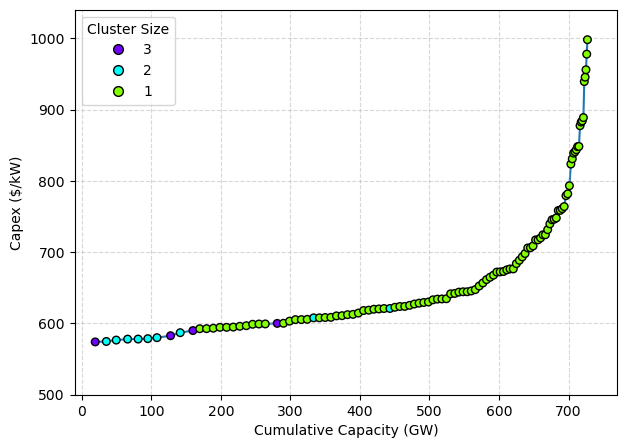

In [124]:
region_df = pd.DataFrame({
    'caps': caps,
    'capex': capex,
    'cluster_size': cluster_size
}).sort_values('capex')
region_df['cumcap'] = region_df['caps'].cumsum()

fig, ax = plt.subplots(1, 1, figsize=(7, 5))

ax.plot(region_df['cumcap'], region_df['capex'], zorder=1)

color_list = generate_color_list(max(region_df['cluster_size']) + 1)
c = [color_list[i] for i in region_df['cluster_size']]

ax.scatter(region_df['cumcap'], region_df['capex'], c=c, s=30, edgecolor='k', zorder=2)
ax.set_xlabel('Cumulative Capacity (GW)')
ax.set_ylabel('Capex ($/kW)')

ax.set_xlim(-10, 770)
ax.set_ylim(500, 1040)
ax.grid(True, linestyle='--', alpha=0.5)

labels = region_df['cluster_size'].unique()
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_list[i], markersize=7,
               markeredgecolor='k', label=f'{i} sites')
           for i in labels]

ax.legend(handles, labels, title='Cluster Size', loc='upper left')


plt.show()

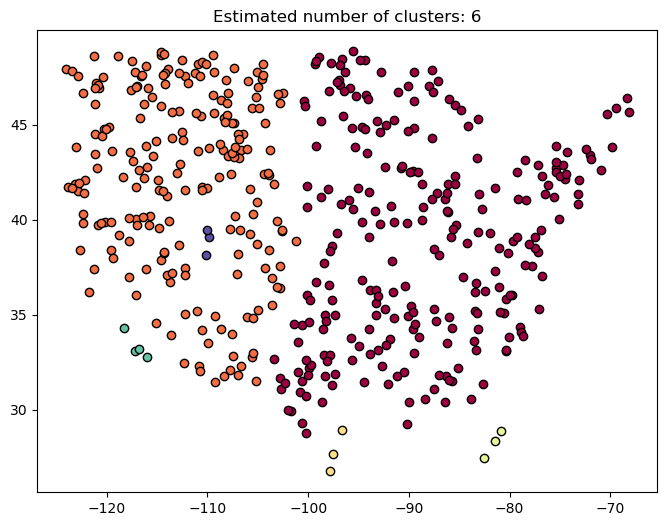

In [13]:
threshold_distance = 2

# Perform DBSCAN clustering
db = DBSCAN(eps=threshold_distance, min_samples=2).fit(sites_np)
labels = db.labels_


# Number of clusters (ignoring noise if any)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

# Plot the results
plt.figure(figsize=(8, 6))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    xy = sites_np[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

plt.title(f'Estimated number of clusters: {n_clusters}')
plt.show()


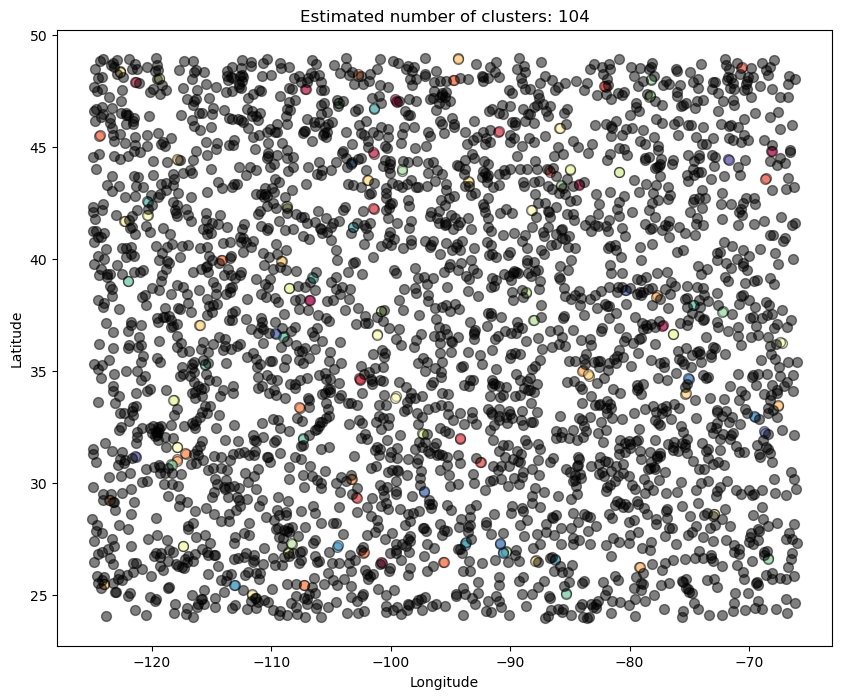

In [16]:
import numpy as np
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
import matplotlib.pyplot as plt

latitudes = np.random.uniform(low=24, high=49, size=3000)
longitudes = np.random.uniform(low=-125, high=-66, size=3000)
sites = np.vstack((latitudes, longitudes)).T

# Define the maximum distance for a cluster in kilometers
threshold_distance_km = 10

# Convert the threshold distance from kilometers to radians (for use with geodesic distance)
threshold_distance_rad = threshold_distance_km / 6371.0  # Earth's radius in km

# Perform DBSCAN clustering based on geographical distance
db = DBSCAN(eps=threshold_distance_rad, min_samples=2, metric='haversine').fit(np.radians(sites))
labels = db.labels_

# Number of clusters (ignoring noise if any)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

# Plotting the results (not geographically accurate but illustrative)
plt.figure(figsize=(10, 8))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]  # Black for noise

    class_member_mask = (labels == k)
    xy = sites[class_member_mask]
    plt.scatter(xy[:, 1], xy[:, 0], color=tuple(col), edgecolor='k', s=50, alpha=0.5)

plt.title(f'Estimated number of clusters: {n_clusters}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
